**X-Ray classification**

**Try all parts for 100 epochs - no data augmentation**

Notes to fix:

1. Run evaluate to train and not test, Fixed!
2. Didn't delete model after fit, fit afresh new dataset, Fixed!
3. DenseNet and ResNet validation_steps and steps_per_epoch, Fix pending!

Given a study containing X-Ray images, build a deep learning model that decides if the study is normal or abnormal. 

You must use at least **2 different architectures**,
* one with your own CNN model (e.g., you can use a model similar to the CNN of the previous project) and 
* one with a popular CNN pre-trained CNN model (e.g., VGG-19, ResNet, etc.). 

Use the MURA dataset to train and evaluate your models. More information about the task and the dataset can be found [here](https://stanfordmlgroup.github.io/competitions/mura/). To download the dataset you must fill out a form, so complete this action as soon as possible.

# Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import matplotlib.image as mpimg
# from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import random, os
import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from glob import glob
import gc
# from skimage.transform import resize

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

from sklearn.metrics import f1_score, recall_score, precision_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
! pip install -q -U keras-tuner
import keras_tuner as kt

import json

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import lib.data_loader as data_loader
import lib.plot_learning_curves as plot_learning_curves
import models.base_model as base_model
import models.densenet as densenet
import models.resnet as resnet

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Tensorflow version 2.4.0
Train model
Tensorflow version 2.4.0
Tensorflow version 2.4.0


In [2]:
# mount data from gdrive and change directory
data_path = 'data/MURA-v1.1/'
directory = 'data/'
! pwd

/tf


# Data  munging

In [4]:
train, test, bodyparts, bodyparts_train_validation_dict, train_generators, valid_generators, test_generators = data_loader.data_loader(data_augmentation='noaugment')


Import train and test data


Create dictionary for training and validation set per body part

No data augmentation

Create dictionary for training, validation and test set per body part

Found 5005 validated image filenames.
Found 538 validated image filenames.
Found 460 validated image filenames.
Found 4590 validated image filenames.
Found 516 validated image filenames.
Found 461 validated image filenames.
Found 8800 validated image filenames.
Found 952 validated image filenames.
Found 659 validated image filenames.
Found 7528 validated image filenames.
Found 851 validated image filenames.
Found 563 validated image filenames.
Found 4427 validated image filenames.
Found 504 validated image filenames.
Found 465 validated image filenames.
Found 1638 validated image filenames.
Found 187 validated image filenames.
Found 301 validated image filenames.
Found 1142 validated image filenames.
Found 130 validated image filenames.
Found 288 validated image filenames.
Data munging completed


# CNN  with no augmentation

## Build

In [5]:
def build_model(input_shape,
                conv_layers,
                conv_activation,
                conv_dropout,
                units,
                output_activation,
                optimizer,
                loss,
                metrics,
                verbose=1):
    
    np.random.seed(1234) # Define the seed for numpy to have reproducible experiments.
    set_seed(9876) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**(i+1)),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=0.2,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Add a dense before output layer and drop out
    x = tf.keras.layers.Dense(units=100,
                              activation='relu',
                              name='Dense-1')(x)

    x = tf.keras.layers.Dropout(rate= 0.2, 
                                name='Dropout-{0:d}'.format(conv_layers + 1))(x)
    # Define the output layer.
    output = Dense(
        units=units,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, 
                  outputs=output)
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    # print summary and architecture
    model.summary()

    return model

In [15]:
def build_cnn_model():
    model = build_model(input_shape = (320,320,3),
                        conv_layers = 4,
                        conv_activation = 'relu',
                        conv_dropout = 0.2,
                        units = 1,
                        output_activation = 'sigmoid',
                        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                        loss = 'binary_crossentropy',
                        metrics = ['binary_accuracy'])
    return model

In [6]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

## Train

In [7]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=8,
                                             verbose=1)    
def train_model(model, bodypart):
    
    validation_steps = math.ceil(valid_generators[bodypart].n/ valid_generators[bodypart].batch_size)
    print("Using validation_steps = %d" % validation_steps)
    steps_per_epoch = math.ceil(train_generators[bodypart].n / (train_generators[bodypart].batch_size))
    print("Using steps_per_epoch = %d" % steps_per_epoch)

    history = model.fit(train_generators[bodypart],
                        validation_data = valid_generators[bodypart],
                        validation_steps = validation_steps,
                        steps_per_epoch = steps_per_epoch,
                        epochs=100,
                        verbose=1,
                        callbacks=[callbacks]
    )
    return history

## Evaluate

In [8]:
def eval_func(y_true, y_prob):
    """
    A function calculating the different evaluation metrics on the test set.
    Converts prediction probabilities y_prob to predicted labels y_pred
    """
    y_pred = np.array([1 if prob >= 0.5 else 0 for prob in y_prob])
    y_true = np.array(y_true)

    print(f"Test accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)} %")
    print(f"Test F1 score: {round(f1_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Precision score: {round(precision_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Recall score: {round(recall_score(y_true, y_pred)*100, 2)} %")

In [19]:
histories_cnn = {}
for bodypart in set(train.bodypart):
    print(bodypart)
    print("\nBuild model\n")
    model = build_cnn_model()
    print('\nTrain model\n')
    print(bodypart)
    histories_cnn[bodypart] = train_model(model, 
                              bodypart)
    print('\nSave training history\n')
    with open("data/history/history_model_cnn_100epochs_noaugment_"+bodypart+".json", "w") as file:
        json.dump(histories_cnn[bodypart].history, file)
    print('\nSave model\n')
    model.save("data/models/model_cnn_100epochs_noaugment_"+bodypart)
    model.save("data/models/model_cnn_100epochs_noaugment_"+bodypart+".h5")
    print('\nEvaluate model\n')
    eval_func(test[test['bodypart'] == bodypart]['class'], 
                    model.predict(test_generators[bodypart]))
    model.evaluate(test_generators[bodypart], verbose=1)
    model.evaluate(train_generators[bodypart], verbose=1)
    model.evaluate(valid_generators[bodypart], verbose=1)
    print("Delete model")
    clean_up(model)

XR_FOREARM

Build model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 160, 160, 32)      4640      
_________________________________________________________________
MaxPool2D-2 (MaxPooling2D)   (None, 80, 80, 32)        0         
_________________________________________________________________
Dropout-2 (Dropout)          (None, 

In [20]:
def plot_learning(history, bodypart):

  fig1  = plt.figure(figsize=(8,4), dpi = 150)

  # summarize history for accuracy
  plt.plot(history.history['binary_accuracy'], c = 'm')
  plt.plot(history.history['val_binary_accuracy'], "--", c = 'c')
  plt.title('Model accuracy for CNN: ' + bodypart, fontsize=16)
  plt.ylabel('accuracy', fontsize=16)
  plt.xlabel('epoch', fontsize=16)
  plt.legend(['train', 'validation'], 
             loc='upper right', 
             fontsize=16)
  # plt.savefig('model_accuracy_cnn_' + bodypart + '.png')
  # files.download('model_accuracy_cnn_' + bodypart + '.png')
  matplotlib.rc('xtick', labelsize=16) 
  matplotlib.rc('ytick', labelsize=16) 

  plt.show()
  plt.savefig('data/plots/accuracy_model_cnn_100epochs_noaugment'+bodypart+'.png')
  plt.clf()
    
  fig2  = plt.figure(figsize=(8,4), dpi = 150)

  # summarize history for loss
  plt.plot(history.history['loss'], c = 'm')
  plt.plot(history.history['val_loss'], "--",  c = 'c')
  plt.title('Model loss for CNN: ' + bodypart, fontsize=16)
  plt.ylabel('loss', fontsize=16)
  plt.xlabel('epoch', fontsize=16)
  plt.legend(['train', 'validation'], 
             loc='upper right', 
             fontsize=16)
  # plt.savefig('model_loss_cnn_' + bodypart + '.png')
  # files.download("model_loss_cnn_" + bodypart + '.png')
  matplotlib.rc('xtick', labelsize=16) 
  matplotlib.rc('ytick', labelsize=16) 
    

  plt.show()
  plt.savefig('data/plots/loss_model_cnn_100epochs_noaugment'+bodypart+'.png')
  plt.clf()

-----------
XR_FOREARM


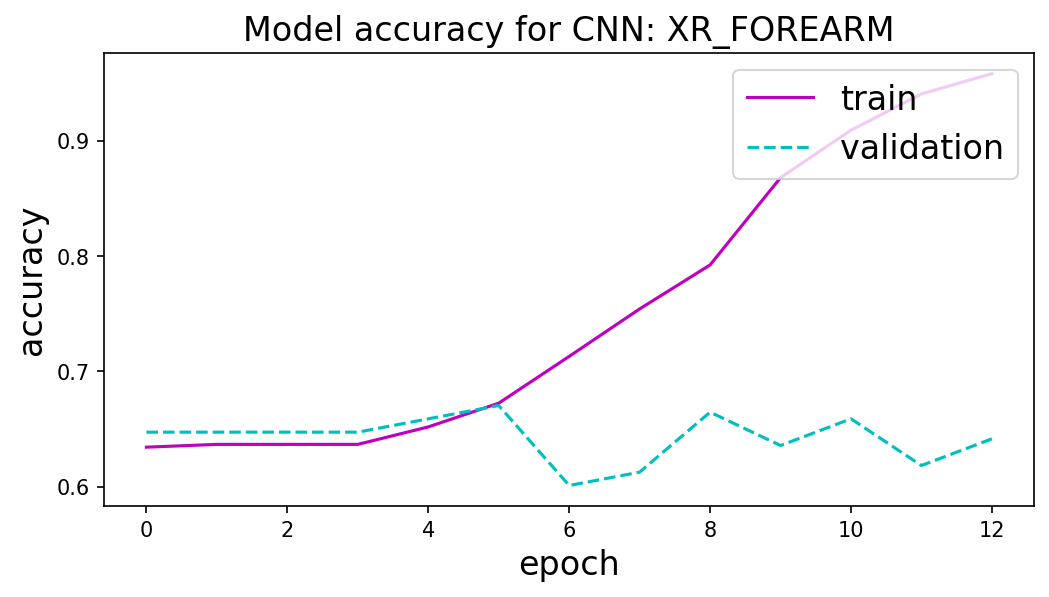

<Figure size 432x288 with 0 Axes>

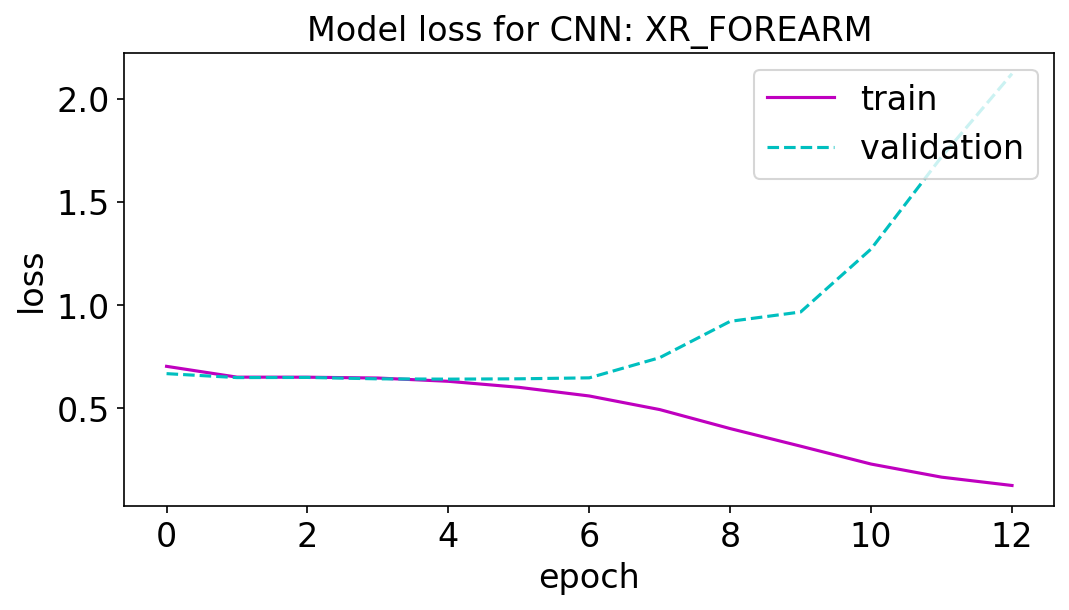

-----------
XR_HAND


<Figure size 432x288 with 0 Axes>

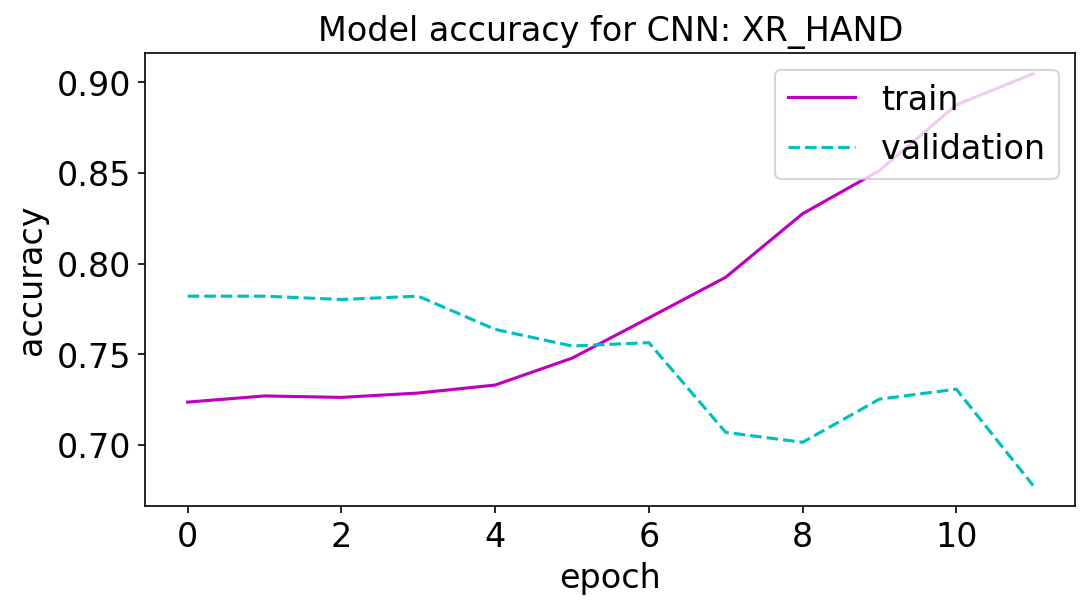

<Figure size 432x288 with 0 Axes>

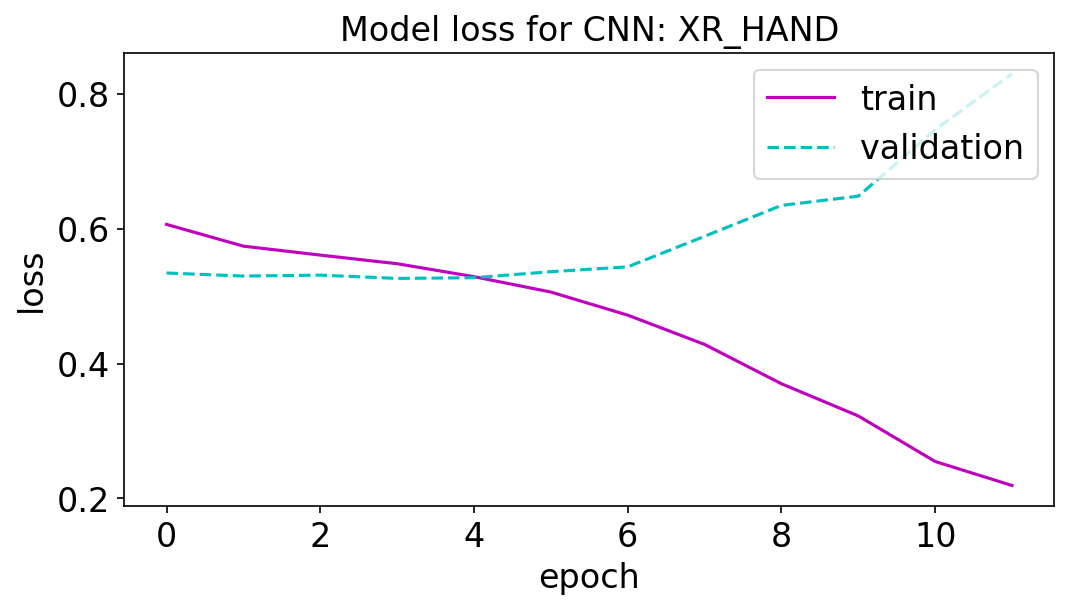

-----------
XR_HUMERUS


<Figure size 432x288 with 0 Axes>

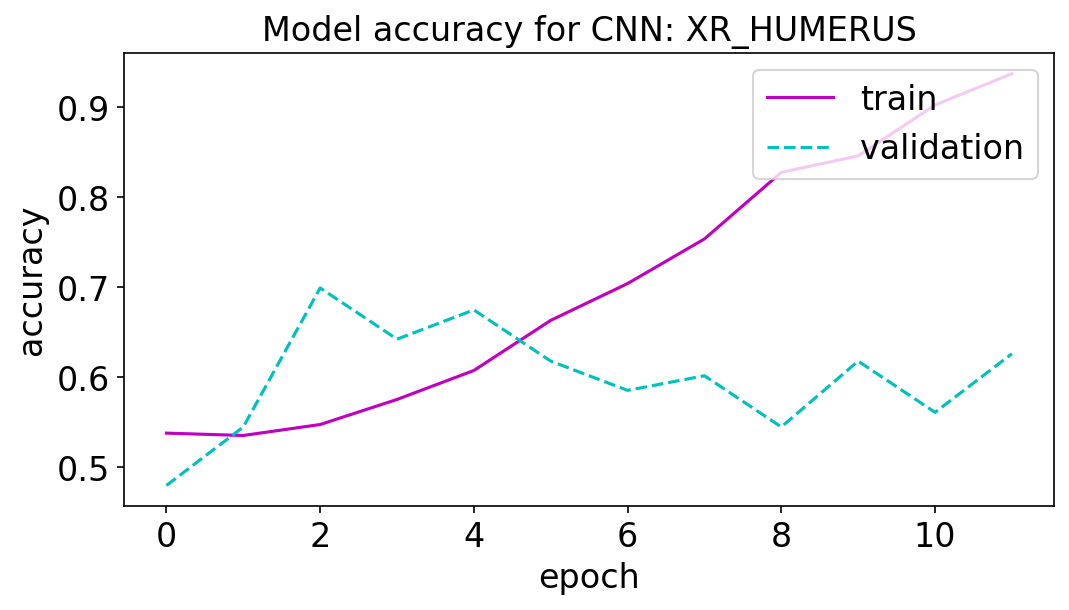

<Figure size 432x288 with 0 Axes>

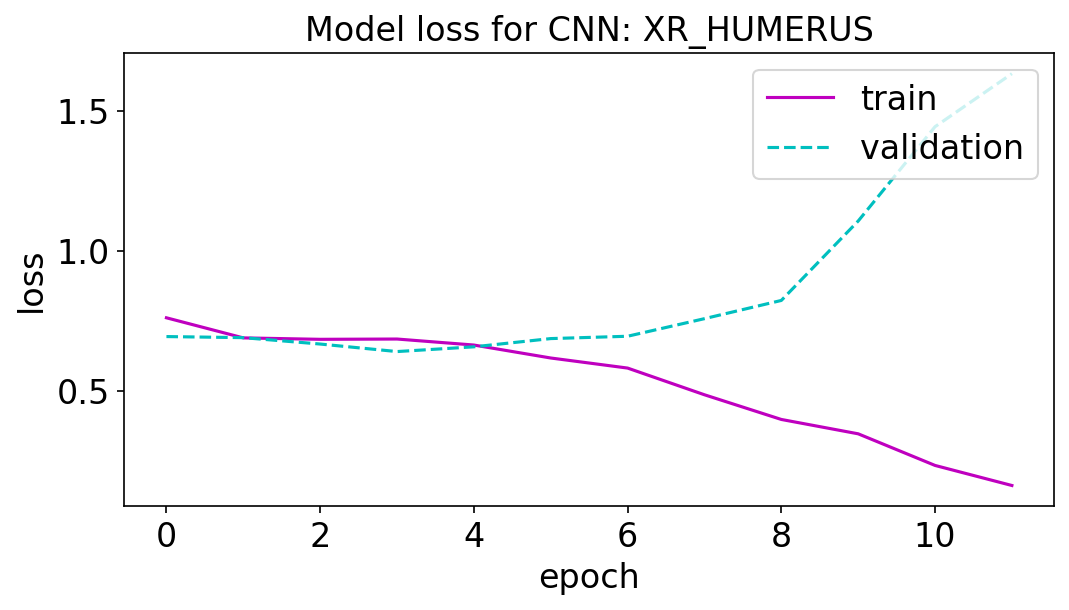

-----------
XR_SHOULDER


<Figure size 432x288 with 0 Axes>

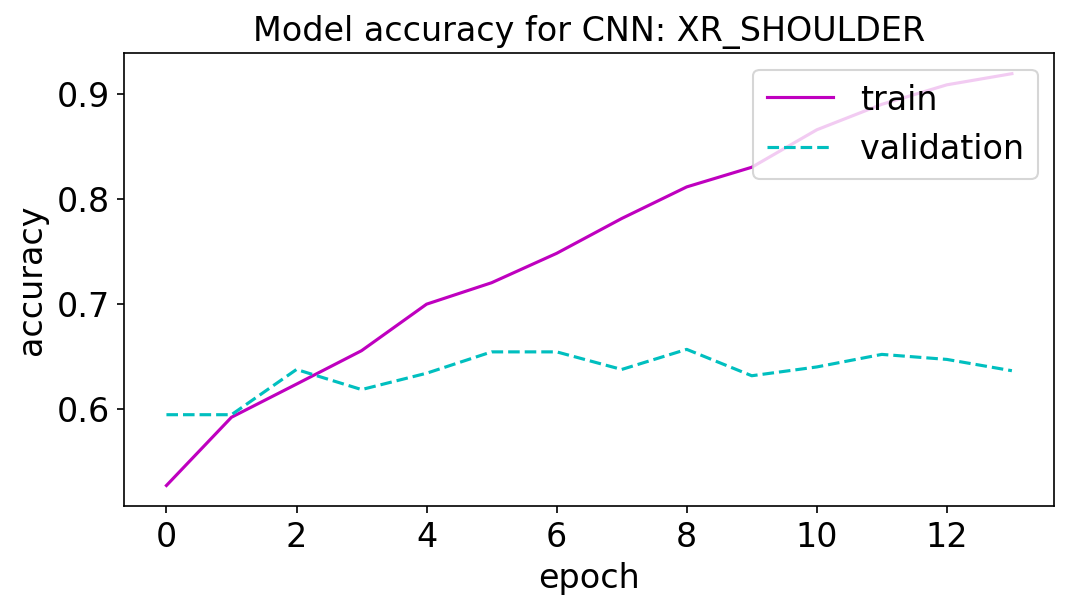

<Figure size 432x288 with 0 Axes>

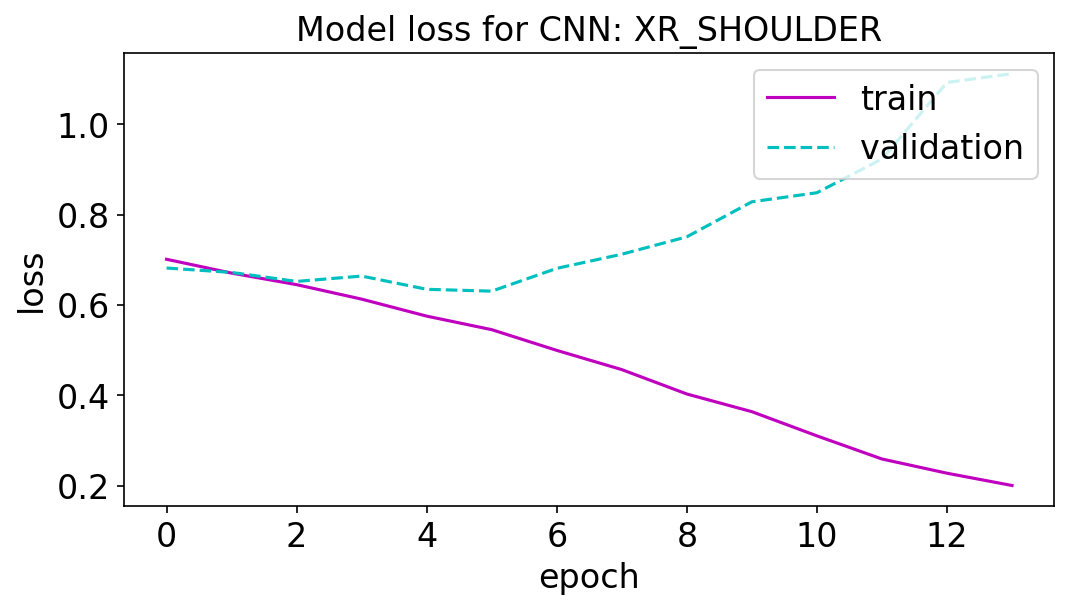

-----------
XR_WRIST


<Figure size 432x288 with 0 Axes>

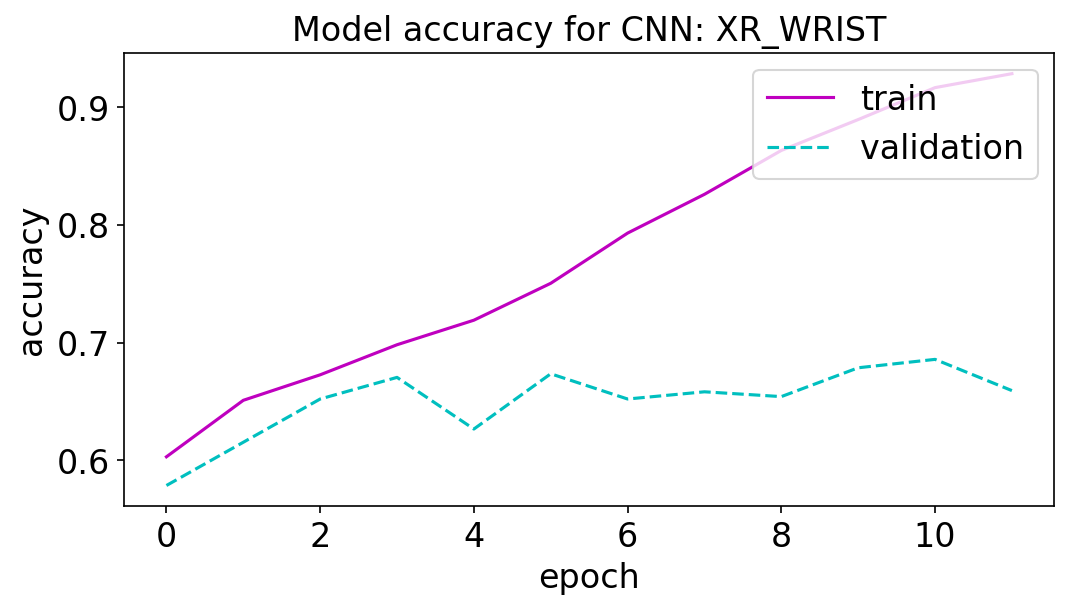

<Figure size 432x288 with 0 Axes>

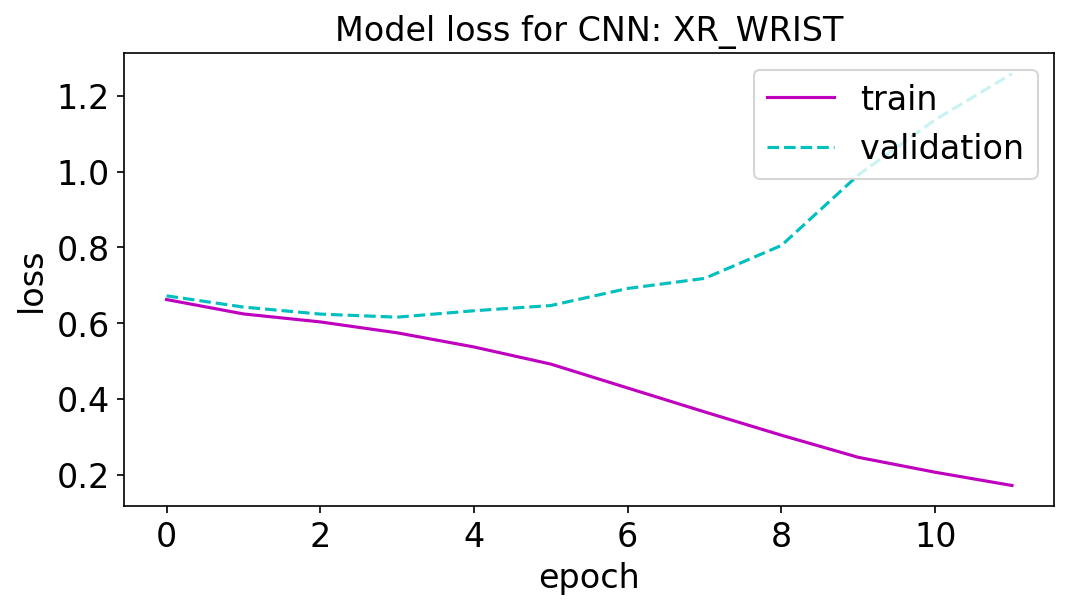

-----------
XR_FINGER


<Figure size 432x288 with 0 Axes>

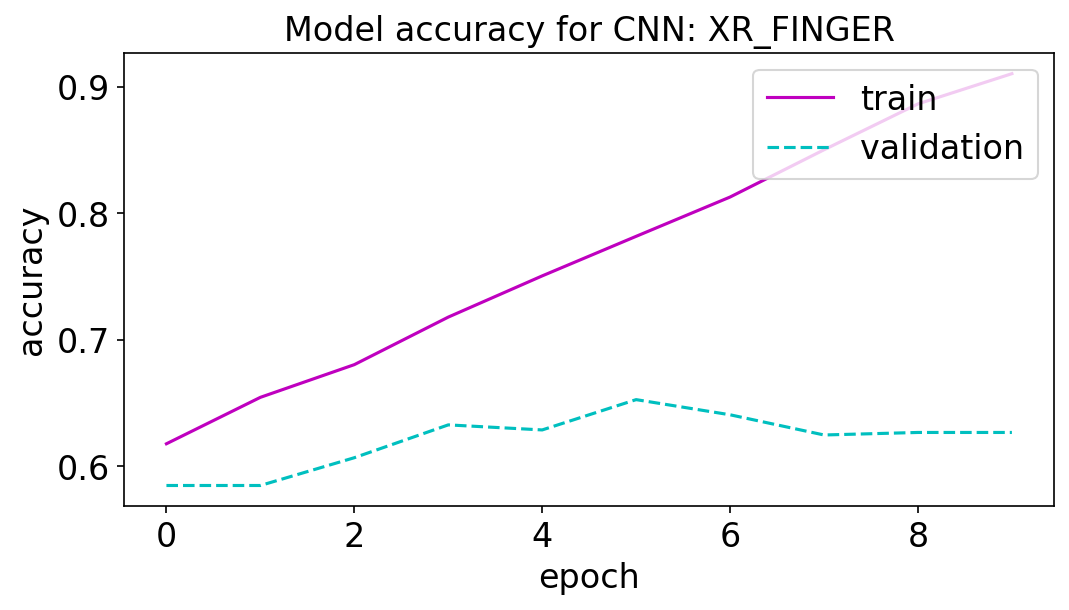

<Figure size 432x288 with 0 Axes>

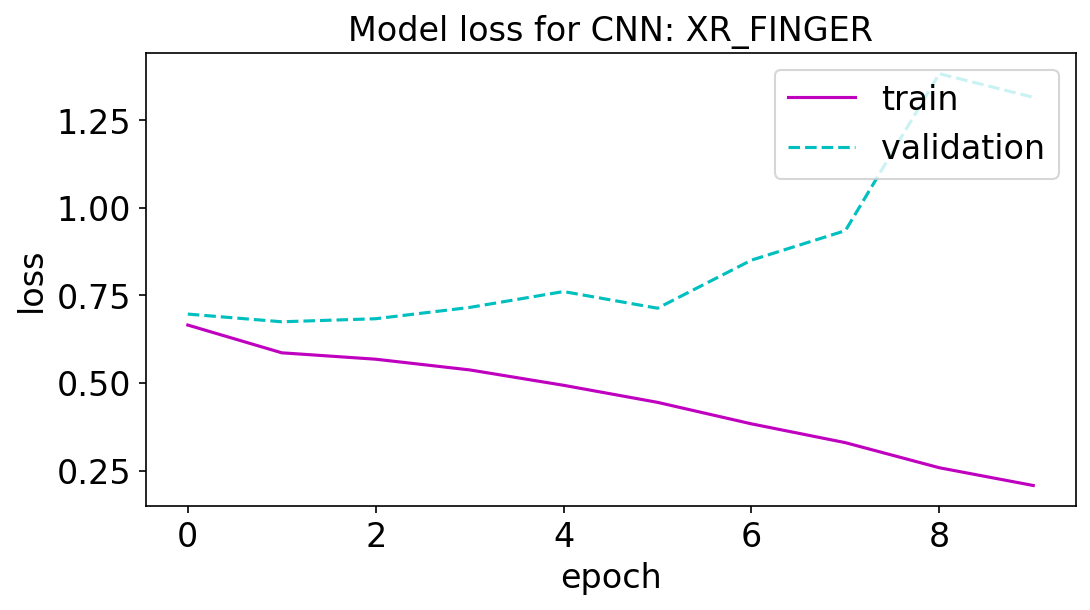

-----------
XR_ELBOW


<Figure size 432x288 with 0 Axes>

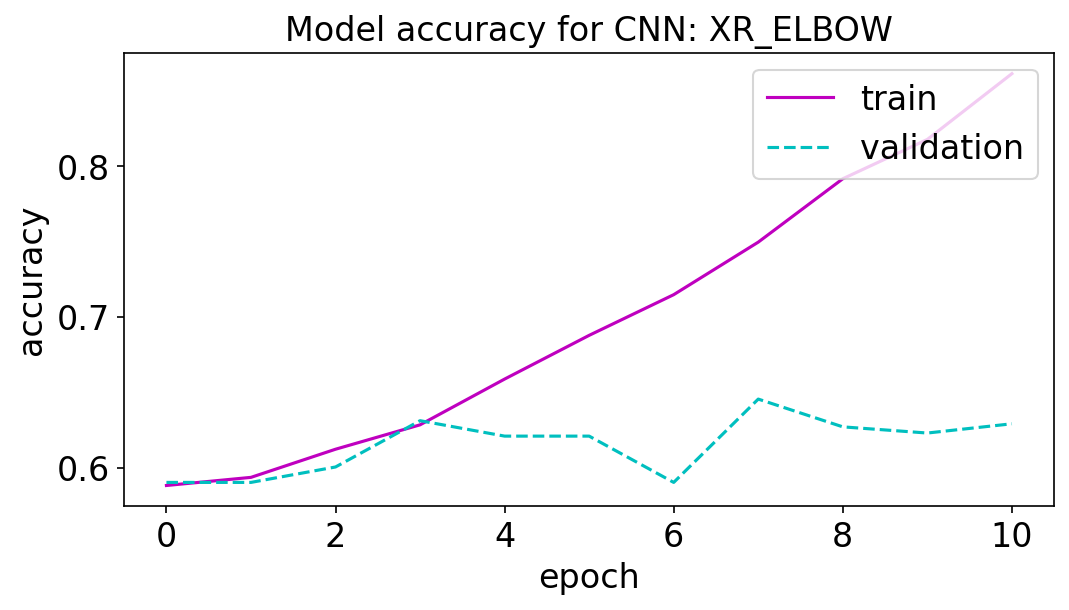

<Figure size 432x288 with 0 Axes>

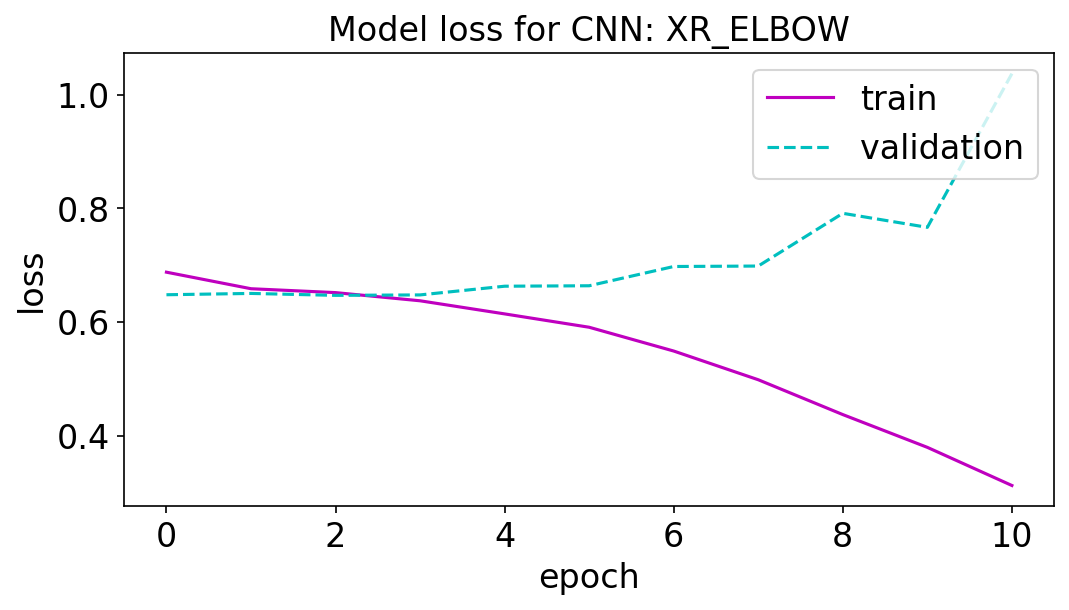

<Figure size 432x288 with 0 Axes>

In [21]:
for bodypart in set(train.bodypart):
    print('-----------')
    print(bodypart)
    plot_learning(histories_cnn[bodypart], 
                  bodypart)

**RUN UP HERE**

# CNN with pre-trained model

## DenseNet

### Build

In [9]:
# add model on top
def build_model_on_densenet():
  # DenseNet model
  densenet_model = tf.keras.applications.DenseNet121(weights='imagenet',
                                                    input_shape = (320,320,3),
                                                    include_top = False)
  densenet_model.trainable = False
  # add new model on top
  inputs = tf.keras.Input(shape=(320,320,3))
  x = densenet_model(inputs, 
                    training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs, outputs)
  model.summary()

  # train the top layer
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss = 'binary_crossentropy',
                metrics = ['binary_accuracy'])
  return model

### Train

In [10]:
callbacks_2 = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                             patience=8,
                                             restore_best_weights=True)

def train_model(model, bodypart):
    validation_steps = math.ceil(valid_generators[bodypart].n/ valid_generators[bodypart].batch_size)
    print("Using validation_steps = %d" % validation_steps)
    steps_per_epoch = math.ceil(train_generators[bodypart].n / (train_generators[bodypart].batch_size))
    print("Using steps_per_epoch = %d" % steps_per_epoch)

    history = model.fit(train_generators[bodypart],
                        validation_data = valid_generators[bodypart],
                        validation_steps = validation_steps,
                        steps_per_epoch = steps_per_epoch,
                        epochs=100,
                        verbose=1,
                        callbacks=[callbacks_2]
    )
    return history

In [14]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [15]:
M

## Done

In [26]:
des_done = ['XR_FOREARM', 
       'XR_HUMERUS',
       'XR_SHOULDER',
       'XR_WRIST']

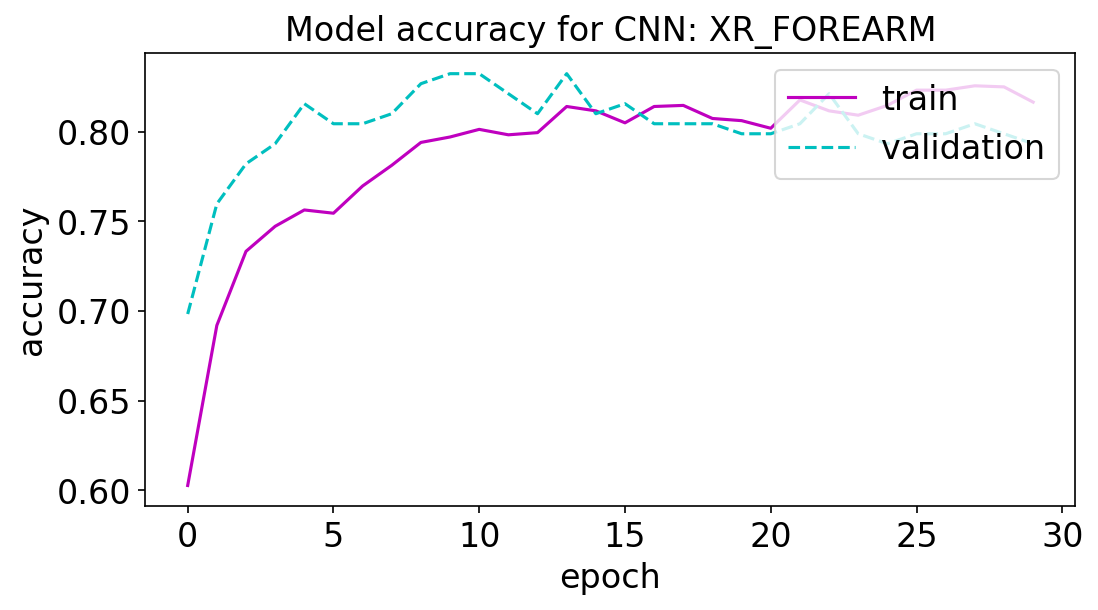

<Figure size 432x288 with 0 Axes>

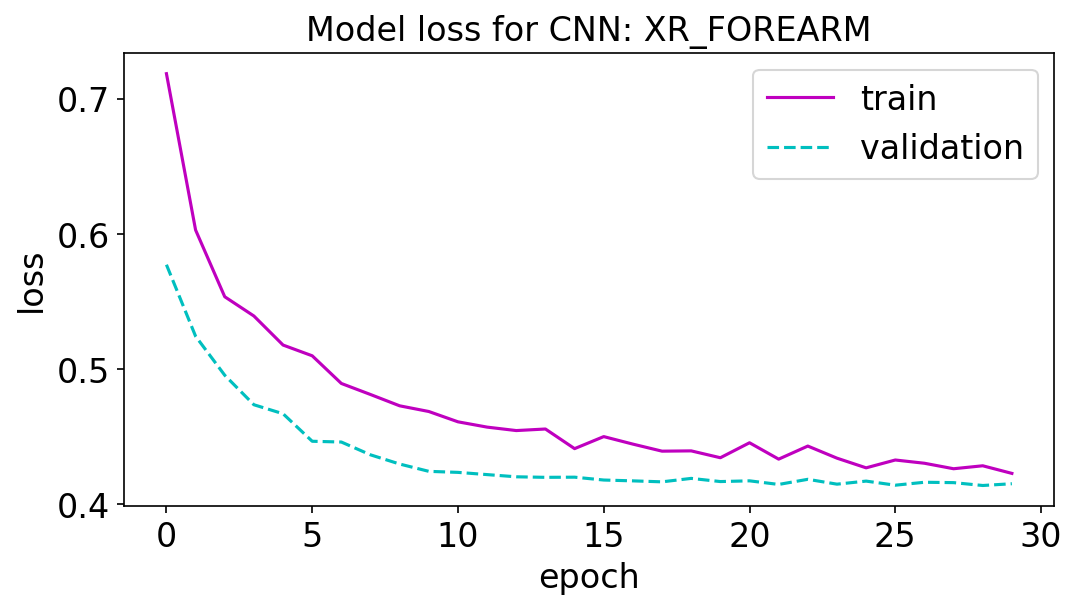

<Figure size 432x288 with 0 Axes>

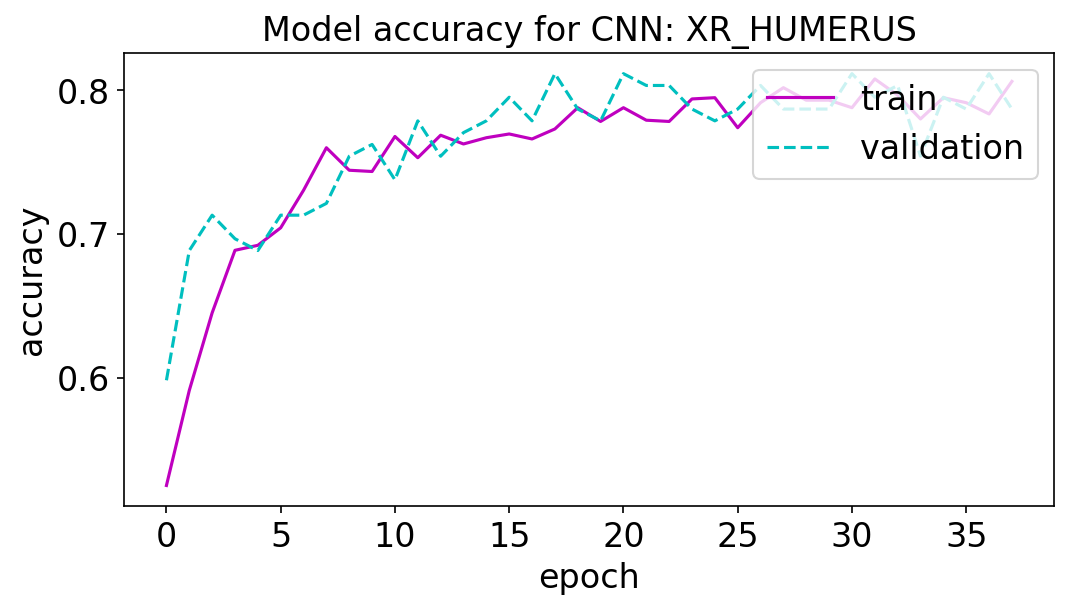

<Figure size 432x288 with 0 Axes>

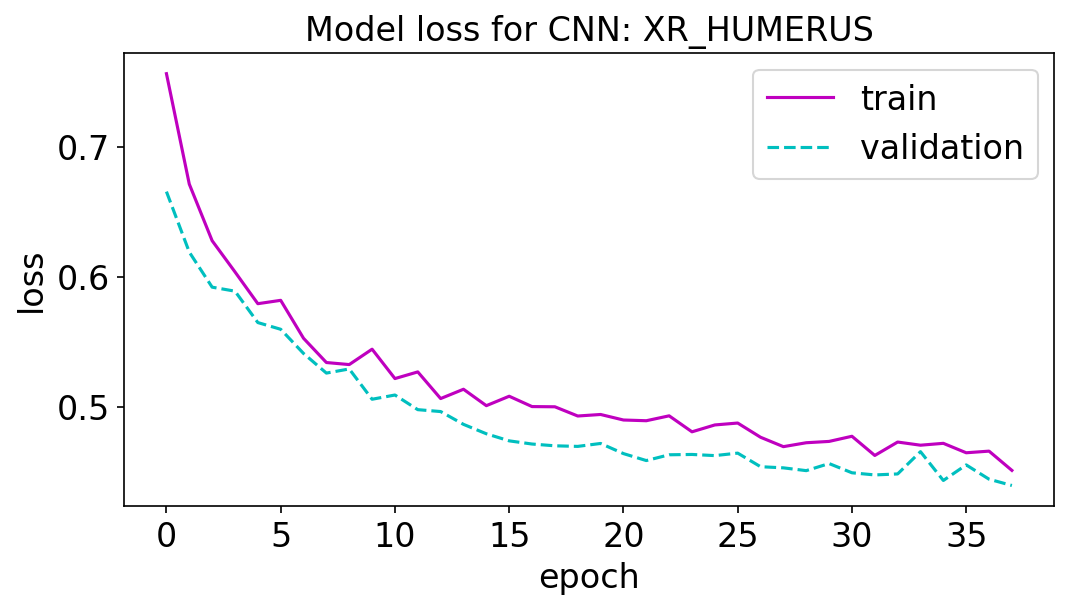

<Figure size 432x288 with 0 Axes>

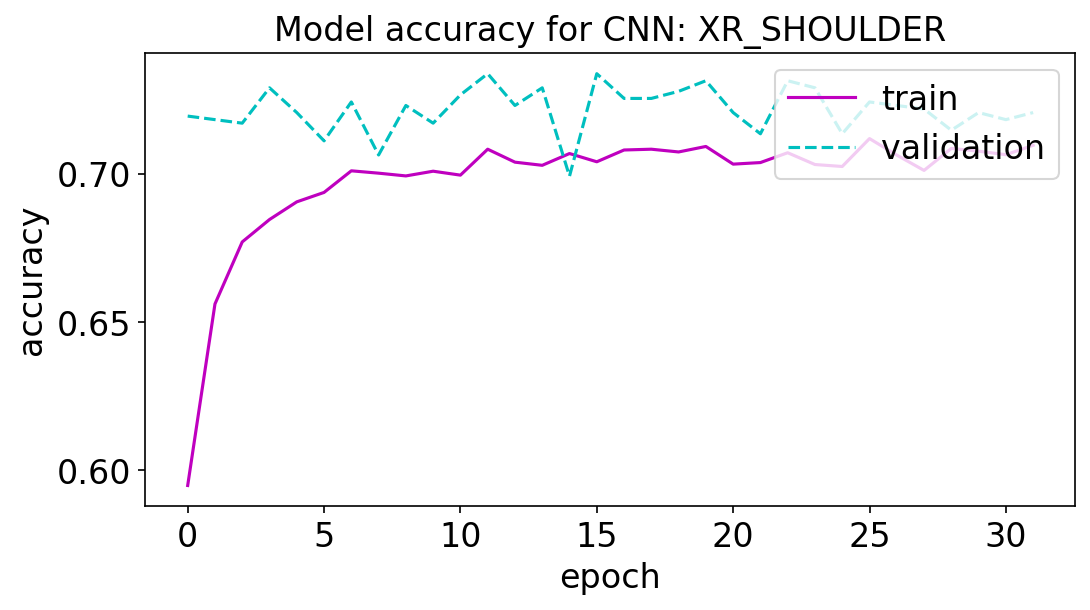

<Figure size 432x288 with 0 Axes>

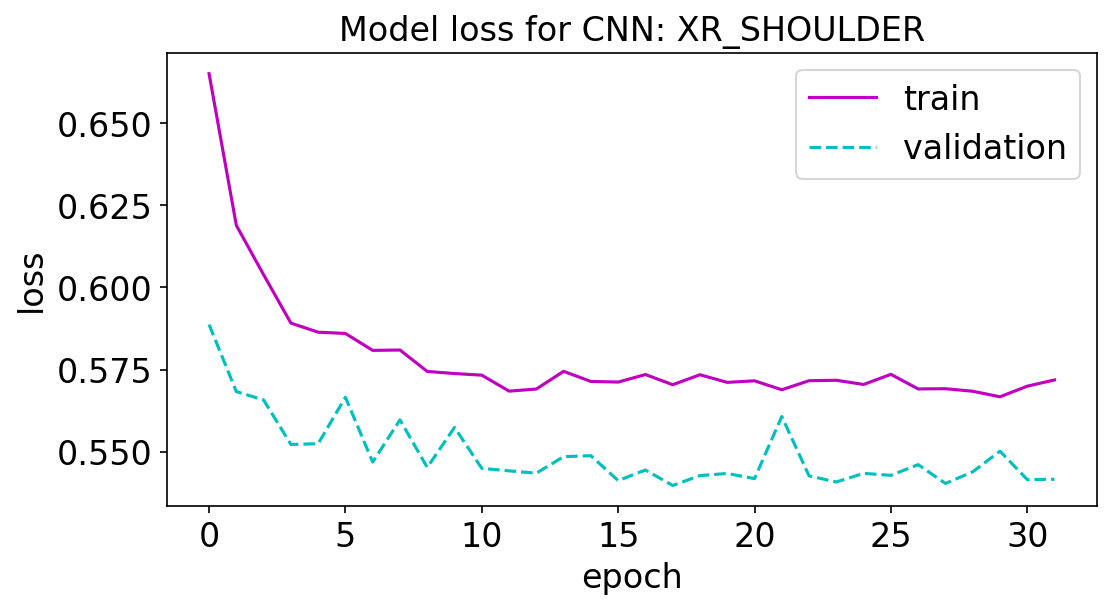

<Figure size 432x288 with 0 Axes>

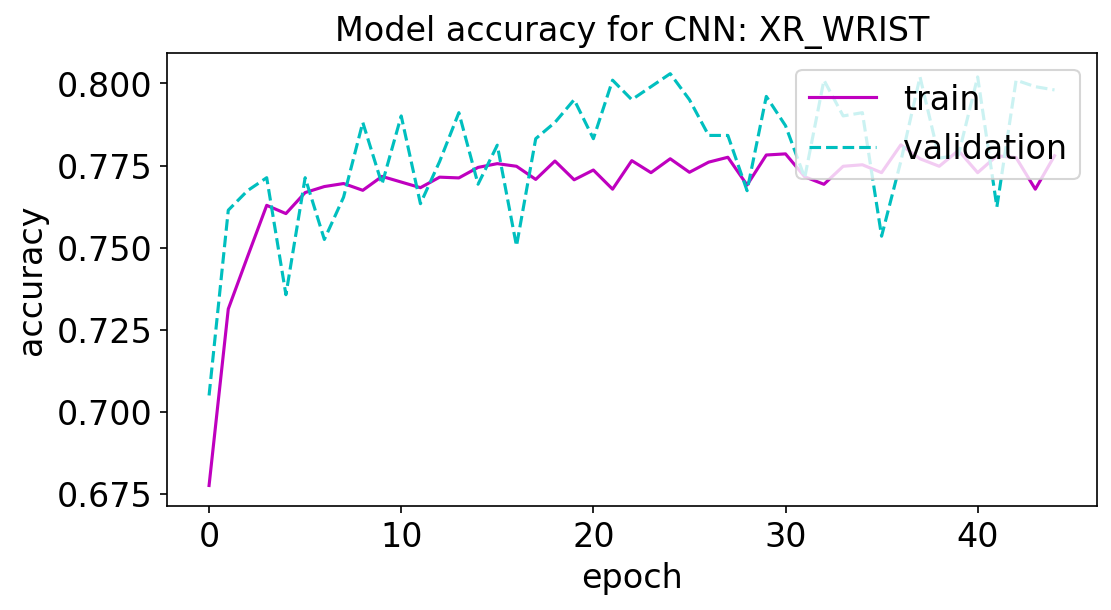

<Figure size 432x288 with 0 Axes>

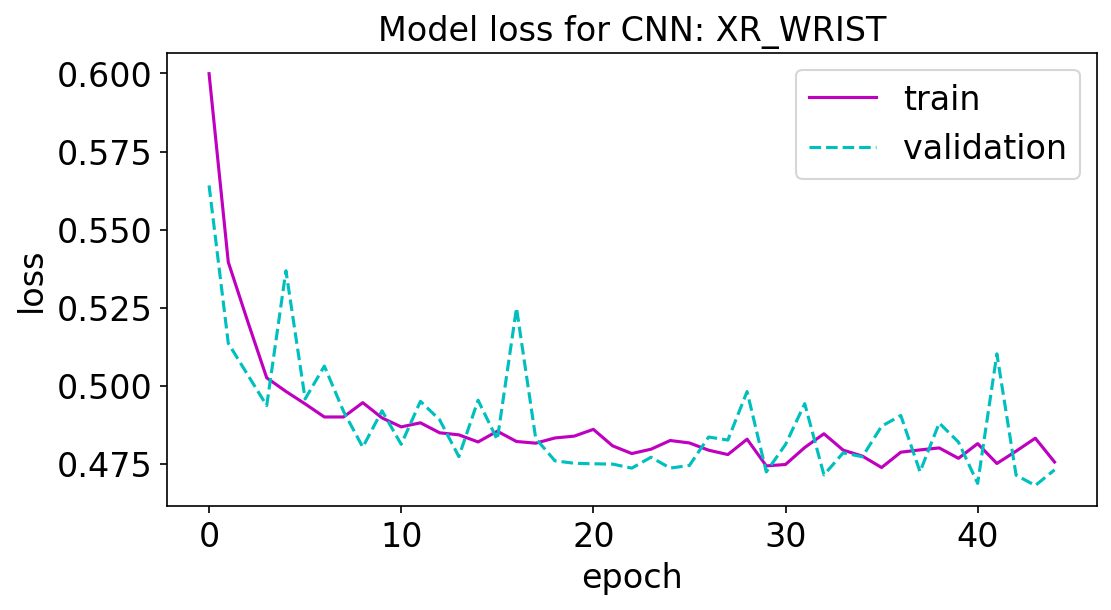

<Figure size 432x288 with 0 Axes>

In [27]:
import json
densenet_model_top_histories_reloaded = {}
for bodypart in des_done:
    url = "data/history/history_densenet_model_top_model_100epochs_noaugment_"+bodypart+".json"
    f = open(url)
    densenet_model_top_histories_reloaded[bodypart] = json.load(f)

for bodypart in des_done:
    plot_learning_curves.plot_history_from_dict(densenet_model_top_histories_reloaded[bodypart], 
                                     bodypart,
                                     'densenet_model_top',
                                     100,
                                     data_augmentation='no_augment')

In [21]:
for bodypart in des_done:
    print("\nLoad model\n")        
    model = keras.models.load_model('data/models/densenet_model_top_100epochs_noaugment_'+bodypart+'.h5') 
    model.evaluate(test_generators[bodypart], verbose=1)
    model.evaluate(train_generators[bodypart], verbose=1)
    model.evaluate(valid_generators[bodypart], verbose=1)
    print("Delete model")
    clean_up(model)


Load model

6/6 [==============================] - 23s 4s/step - loss: 0.4130 - binary_accuracy: 0.8182
Delete model

Load model

5/5 [==============================] - 15s 3s/step - loss: 0.5472 - binary_accuracy: 0.7385
Delete model

Load model

27/27 [==============================] - 125s 5s/step - loss: 0.5257 - binary_accuracy: 0.7556
Delete model

Load model

30/30 [==============================] - 134s 4s/step - loss: 0.4546 - binary_accuracy: 0.8067
Delete model


## Pending

In [22]:
pending = ['XR_ELBOW',
           'XR_FINGER', 
           'XR_HAND']

In [24]:
densenet_model_top_histories = {}

for bodypart in pending:
    print(bodypart)   
    print("\nBuild model\n")
    model = build_model_on_densenet()
    print('\nTrain model\n')
    print(bodypart)
    densenet_model_top_histories[bodypart] = train_model(model, 
                                                         bodypart)
    print('\nSave training history\n')
    with open("data/history/history_densenet_model_top_model_100epochs_noaugment_"+bodypart+".json", "w") as file:
        json.dump(densenet_model_top_histories[bodypart].history, file)
        print('\nSave model\n')
    model.save("data/models/densenet_model_top_100epochs_noaugment_"+bodypart)
    model.save("data/models/densenet_model_top_100epochs_noaugment_"+bodypart+".h5")
    print('\nEvaluate model\n')
    eval_func(test[test['bodypart'] == bodypart]['class'], 
                    model.predict(test_generators[bodypart]))
    model.evaluate(test_generators[bodypart], verbose=1)
    model.evaluate(train_generators[bodypart], verbose=1)
    model.evaluate(valid_generators[bodypart], verbose=1)
    print("Delete model")
    clean_up(model)

XR_ELBOW

Build model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 1,025
Non-trainable params: 7,037,504
_________________________________________________________________

Train model

XR_ELBOW
Using validation_steps = 16
Using steps_per_epoch = 139
Epoch 1/1

XR_ELBOW


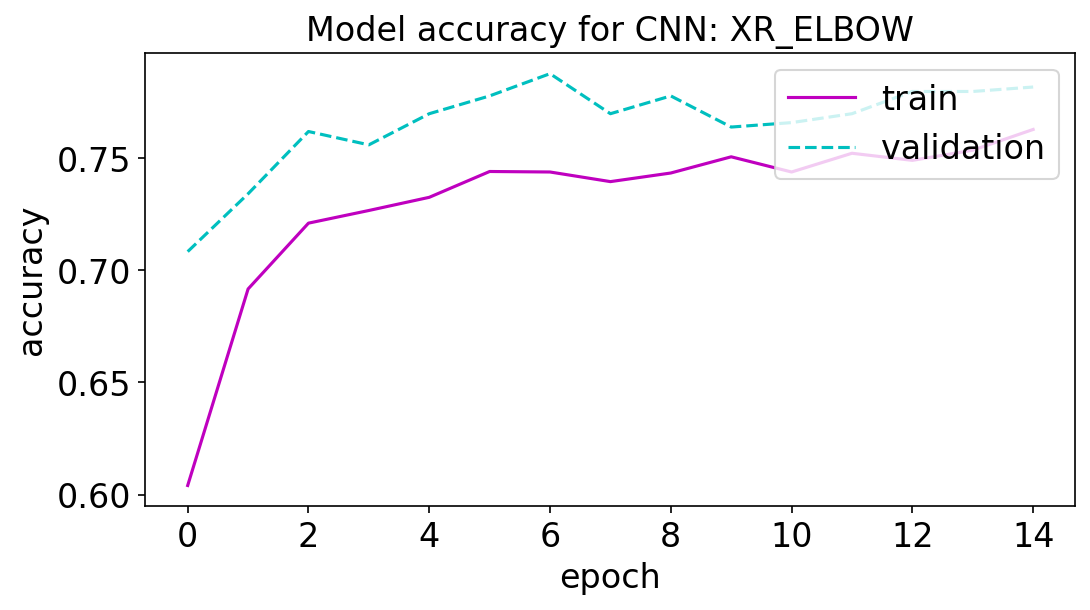

<Figure size 432x288 with 0 Axes>

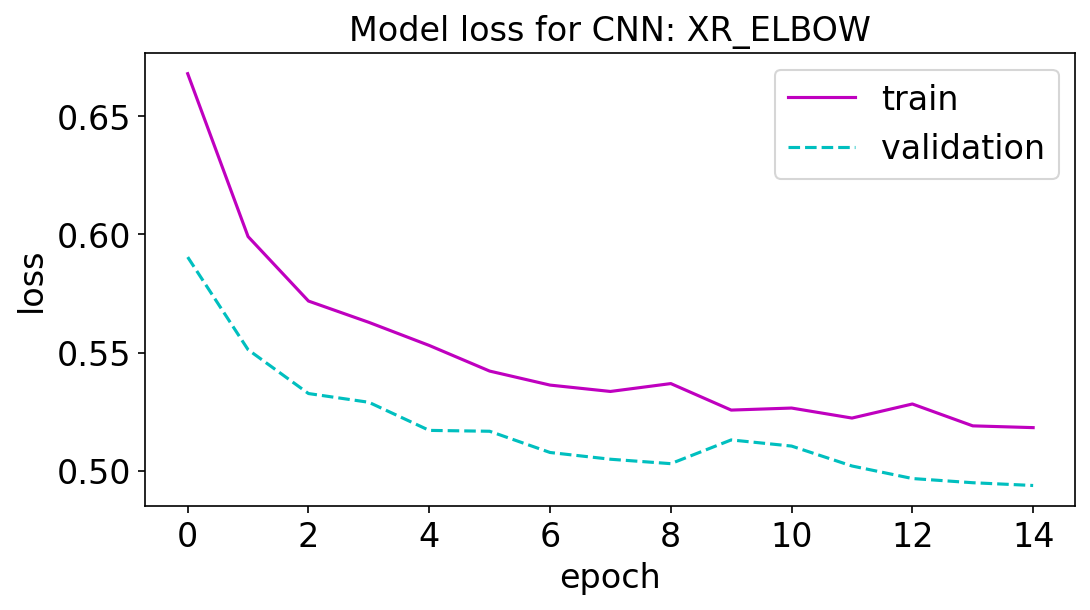

XR_FINGER


<Figure size 432x288 with 0 Axes>

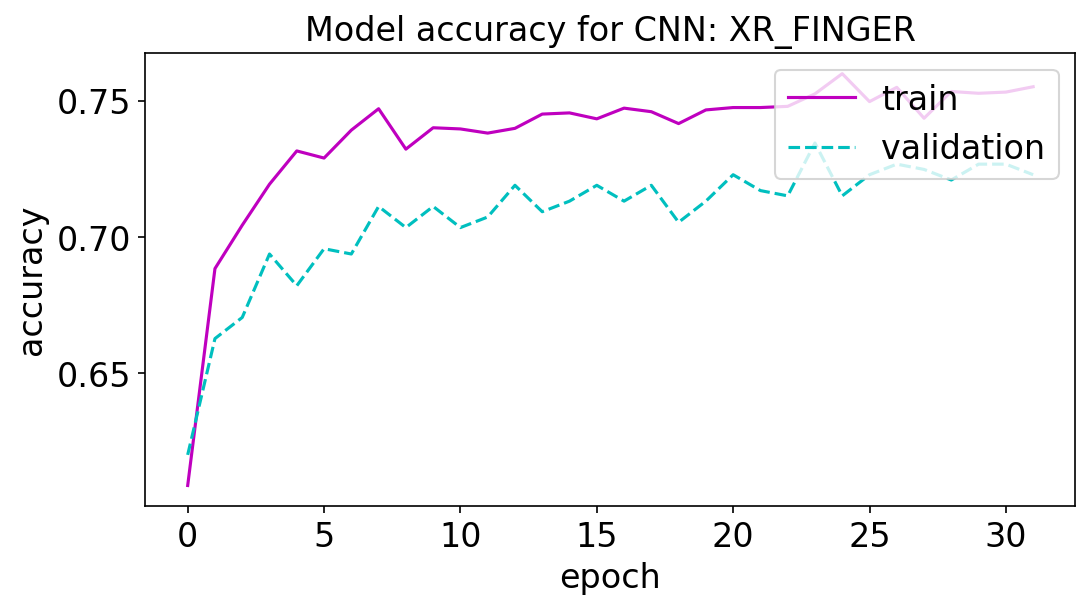

<Figure size 432x288 with 0 Axes>

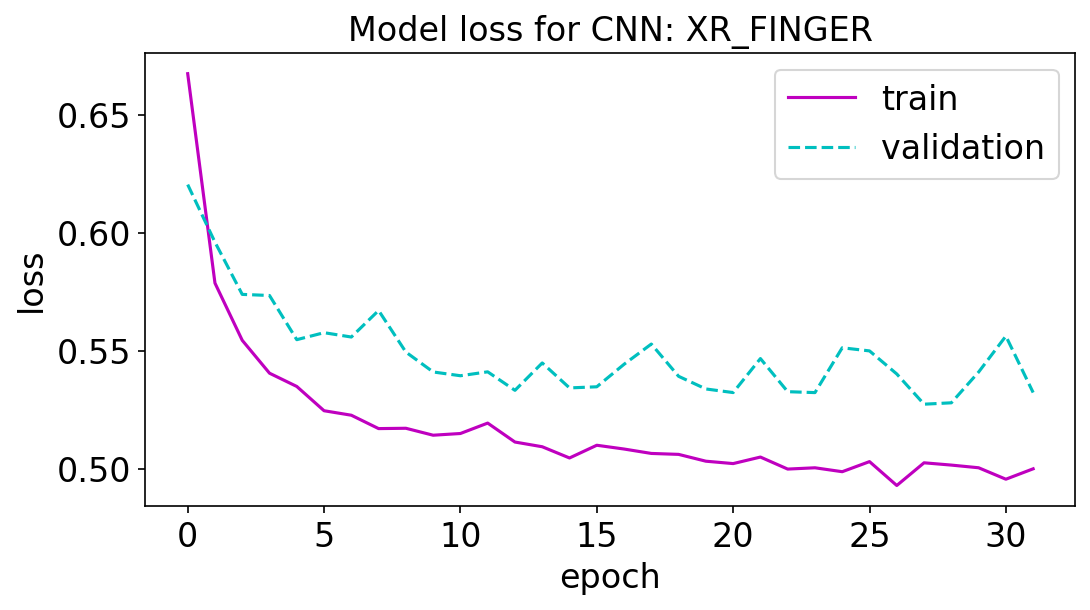

XR_HAND


<Figure size 432x288 with 0 Axes>

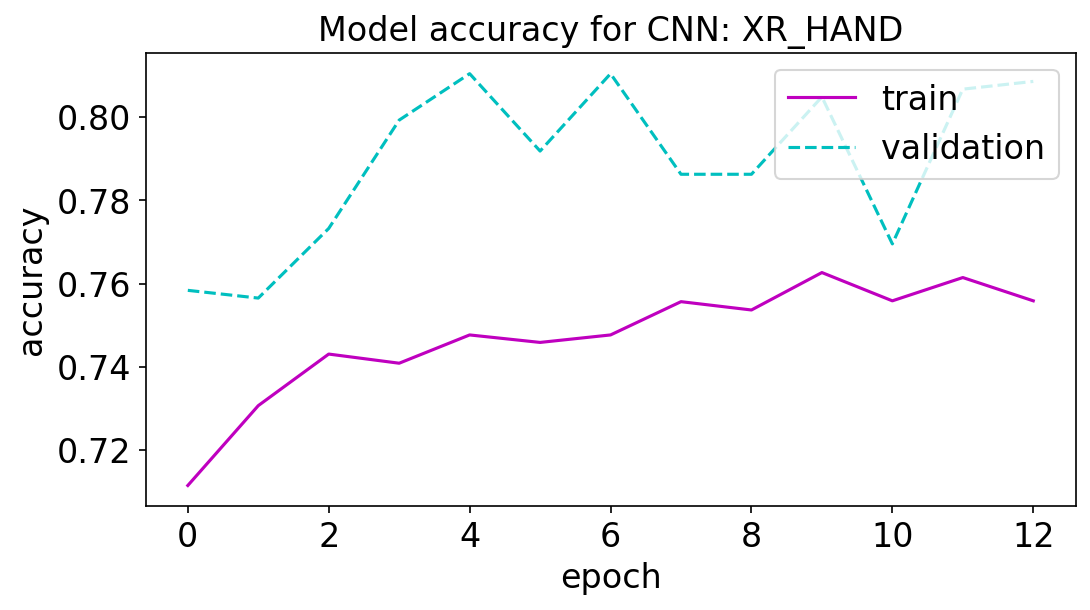

<Figure size 432x288 with 0 Axes>

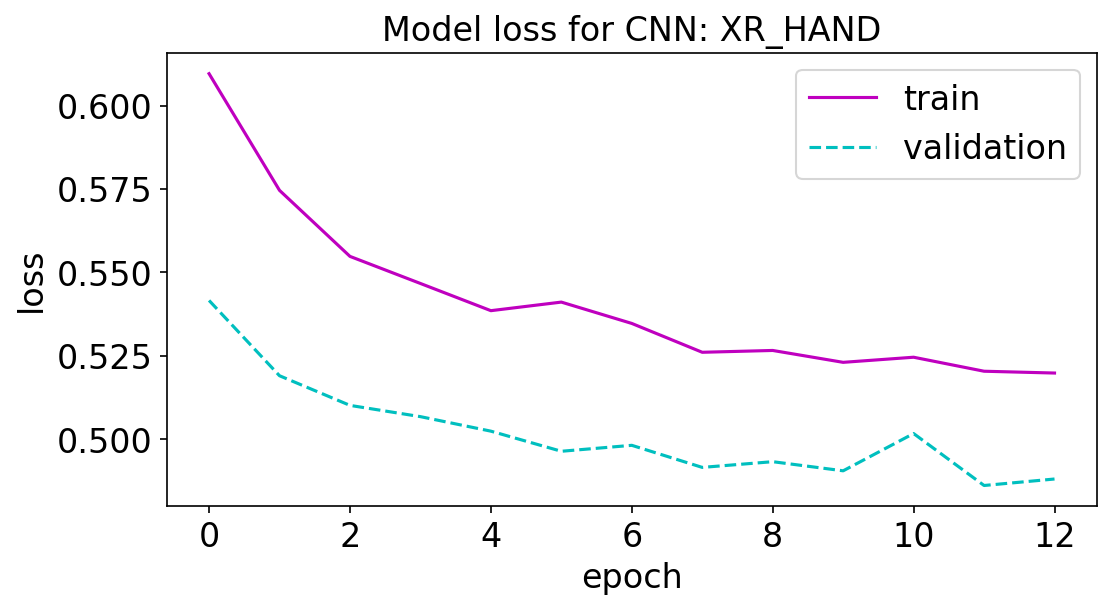

<Figure size 432x288 with 0 Axes>

In [25]:
for bodypart in pending:
    print(bodypart)
    plot_learning_curves.plot_history(densenet_model_top_histories[bodypart], 
                                      bodypart,
                                        'densenet_model_top',
                                        100,
                                        data_augmentation='no_augment')

In [ ]:
# densenet_model_top_histories = {}

# for bodypart in set(train.bodypart):
#     print(bodypart)
#     print("\nBuild model\n")
#     model = build_model_on_densenet()
#     print('\nTrain model\n')
#     print(bodypart)
#     densenet_model_top_histories[bodypart] = train_model(model, 
#                                                          bodypart)
#     print('\nSave training history\n')
#     with open("data/history/history_densenet_model_top_model_100epochs_noaugment_"+bodypart+".json", "w") as file:
#         json.dump(densenet_model_top_histories[bodypart].history, file)
#         print('\nSave model\n')
#     model.save("data/models/densenet_model_top_100epochs_noaugment_"+bodypart)
#     model.save("data/models/densenet_model_top_100epochs_noaugment_"+bodypart+".h5")
#     print('\nEvaluate model\n')
#     eval_func(test[test['bodypart'] == bodypart]['class'], 
#                     model.predict(test_generators[bodypart]))
#     model.evaluate(test_generators[bodypart], verbose=1)
#     print("Delete model")
#     clean_up(model)